In [1]:
import pandas as pd
import numpy as np
import math
from pyqstrat.pq_utils import *
from pyqstrat.strategy import Strategy
from pyqstrat.account import Account
from pyqstrat.portfolio import Portfolio
from pyqstrat.evaluator import plot_return_metrics
from pyqstrat.pq_types import Contract, Trade
from pyqstrat.marketdata import MarketData, MarketDataCollection
from pyqstrat.orders import StopLimitOrder, MarketOrder

set_defaults()

running
done


<Figure size 432x288 with 0 Axes>

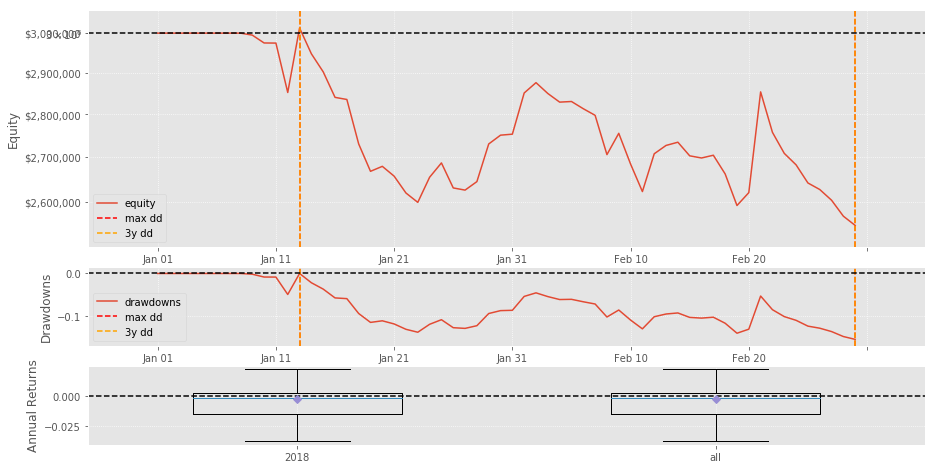

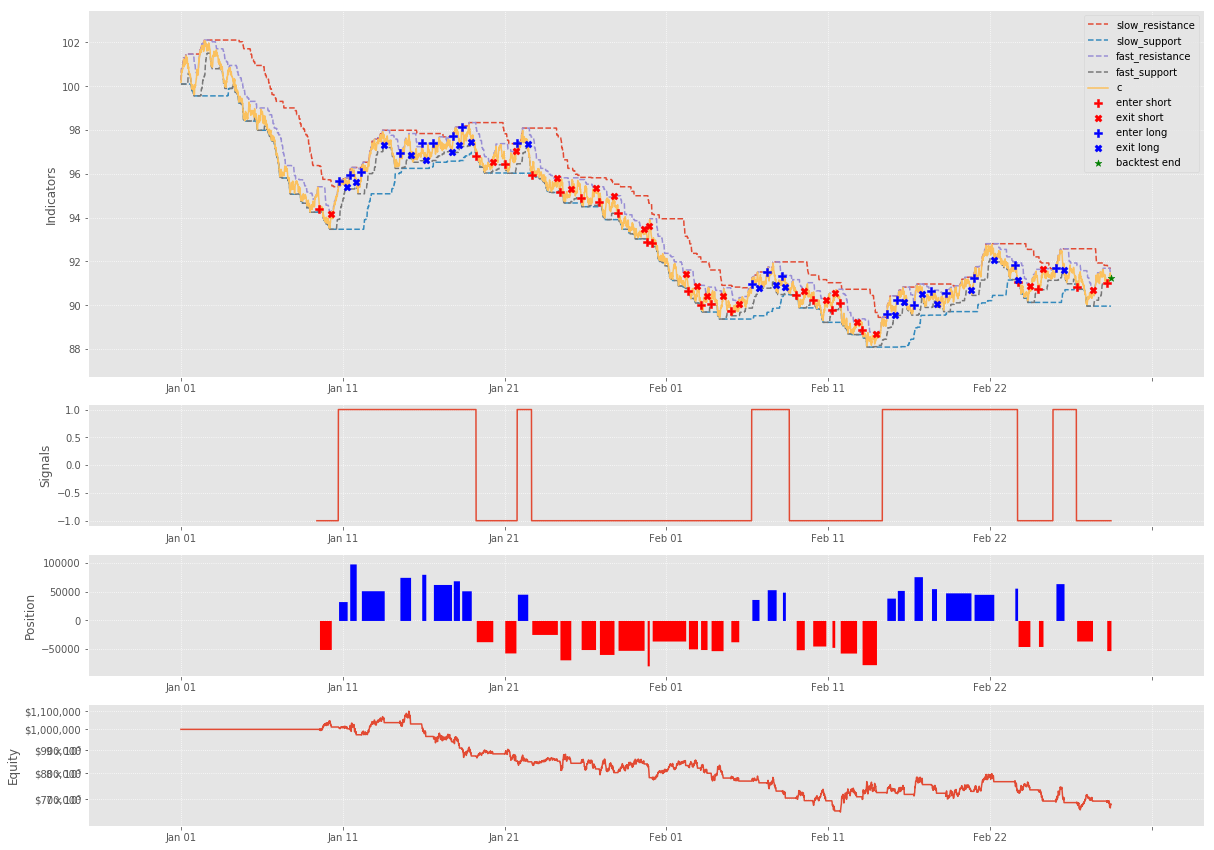

In [2]:
def sim_order(order, i, date, md):
    symbol = order.symbol
    trade_price = np.nan
    skid_fraction = 0.5

    if not md.valid_row(i): return None

    if isinstance(order, MarketOrder):
        if order.qty > 0:
            trade_price = 0.5 * (md.c[i] + md.h[i])
        else:
            trade_price = 0.5 * (md.c[i] + md.l[i])
    elif order.qty > 0 and md.h[i] > order.trigger_price:
        trade_price = skid_fraction * max(md.o[i], order.trigger_price, md.l[i]) + (1 - skid_fraction) * md.h[i]
    elif order.qty < 0 and md.l[i] < order.trigger_price:
        trade_price = skid_fraction * min(md.o[i], order.trigger_price, md.h[i]) + (1 - skid_fraction) * md.l[i]
    else:
        return None
    sim_trade = Trade(symbol, date, order.qty, trade_price, order = order)
    return sim_trade

def market_simulator(strategy, orders, i, date, marketdata):
    trades = []
    for order in orders:
        sim_trade = sim_order(order, i, date, marketdata)
        if sim_trade is None: continue
        if math.isclose(sim_trade.qty, order.qty): order.status = 'filled'

        trades.append(sim_trade)
    return trades

def trade_rule(strategy, symbol, i, date, marketdata, indicator_values, signal_values, account):
    heat = 0.05
    reason_code = None

    if not marketdata.valid_row(i): return []

    curr_pos = account.position(symbol, date)

    if i == len(marketdata.dates) - 2: # Last date so get out of position
        if not math.isclose(curr_pos, 0): 
            return [MarketOrder(symbol, date, -curr_pos, reason_code = ReasonCode.BACKTEST_END)]
        else:
            return []

    trend = signal_values[i]
    fast_resistance, fast_support, slow_resistance, slow_support = (indicator_values['fast_resistance'][i], 
            indicator_values['fast_support'][i], indicator_values['slow_resistance'][i], indicator_values['slow_support'][i])

    if trend == 1:
        entry_limit = fast_resistance
        stop_limit = fast_support
    elif trend == -1:
        entry_limit = fast_support
        stop_limit = fast_resistance
    else:
        return []

    if math.isclose(curr_pos, 0): # We got a trade in the previous bar so put in a stop limit order
        if math.isclose(entry_limit, stop_limit): return []
        curr_equity = account.equity(date)
        order_qty = curr_equity * heat / (entry_limit - stop_limit)
        trigger_price = entry_limit
        reason_code = ReasonCode.ENTER_LONG if order_qty > 0 else ReasonCode.ENTER_SHORT
    else:
        order_qty = -curr_pos
        trigger_price = stop_limit
        reason_code = ReasonCode.EXIT_LONG if order_qty < 0 else ReasonCode.EXIT_SHORT

    order_qty = round(order_qty)

    if np.isnan(order_qty):
        raise Exception(f'Got nan order qty date: {date} i: {i} curr_pos: {curr_pos} curr_equity: {curr_equity} entry_limit: {entry_limit} stop_limit: {stop_limit}')

    if math.isclose(order_qty, 0): return []

    order = StopLimitOrder(symbol, date, order_qty, trigger_price, reason_code = reason_code)

    return [order]

def get_support(lows, n): return pd.Series(lows).rolling(window = n, min_periods = 1).min().values

def get_resistance(highs, n): return pd.Series(highs).rolling(window = n, min_periods = 1).max().values

def get_trend(md, ind):
    trend = pd.Series(np.where(pd.Series(md.h) > shift_np(ind['slow_resistance'], 1), 1, 
                      np.where(pd.Series(md.l) < shift_np(ind['slow_support'], 1), -1, 
                      np.nan)))
    trend.fillna(method = 'ffill', inplace = True)
    return trend.values

def build_strategy(contract, marketdata_collection, fast_interval, slow_interval):
    strategy = Strategy([contract], marketdata_collection)
    strategy.add_indicator('slow_resistance', lambda md : get_resistance(md.h, slow_interval))
    strategy.add_indicator('slow_support', lambda md : get_support(md.l, slow_interval))
    strategy.add_indicator('fast_resistance', lambda md : get_resistance(md.h, fast_interval))
    strategy.add_indicator('fast_support', lambda md : get_support(md.l, fast_interval))
    strategy.add_signal('trend', get_trend)
    strategy.add_market_sim(market_simulator)
    strategy.add_rule('trade_rule', trade_rule, 'trend', np.array([-1, 1]))
    return strategy
    
def test_portfolio():
    
    np.random.seed(0)
    dates = np.arange(datetime.datetime(2018, 1, 1, 9, 0, 0), datetime.datetime(2018, 3, 1, 16, 0, 0), datetime.timedelta(minutes = 5))
    dates = np.array([dt for dt in dates.astype(object) if dt.hour >= 9 and dt.hour <= 16]).astype('M8[m]')
    rets = np.random.normal(size = len(dates)) / 1000
    c_0 = 100
    c = np.round(c_0 * np.cumprod(1 + rets), 2)
    l = np.round(c * (1. - np.abs(np.random.random(size = len(dates)) / 1000.)), 2)
    h = np.round(c * (1. + np.abs(np.random.random(size = len(dates)) / 1000.)), 2)
    o = np.round(l + (h - l) * np.random.random(size = len(dates)), 2)
    v = np.round(np.random.normal(size = len(dates)) * 100)
    vwap = 0.5 * (h + l)
    
    portfolio = Portfolio()
    
    slow_interval = 0
    
    for days in [0.5, 1, 2]:
        # 1 day from 9 - 4 pm has 7 hours which translate to 7 x 12 = 84 5 minute periods
        fast_interval = round(days * 84) 
        slow_interval = round(5 * fast_interval)
        contract = Contract('IBM')
        marketdata_collection = MarketDataCollection(['IBM'], [MarketData(dates, c, o, h, l, v, vwap)])
        portfolio.add_strategy(f'strat_{days}', build_strategy(contract, marketdata_collection, fast_interval, slow_interval))
    
    # Start at max slow days so all strategies start at the same time
    print('running')
    portfolio.run(start_date = dates[slow_interval])
    print('done')
    
    strat1 = portfolio.strategies['strat_0.5']
    portfolio.plot();
    strat1.plot();
    
if __name__ == "__main__":
    test_portfolio()
